In [38]:
import pandas as pd
import numpy as np
import sklearn as sk
import tsfresh as ts


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

<h3>Data Preparation:</h3>

<h4>Definition der Dataframes:</h4>

Einlesen der Dateien als Dataframes aufgeteilt nach verschiedenen Sensoren (Accelerometer, Gyroscope, Orientation, Gravity)

Datenaufzeichnung mit Aktivitäten des alltäglichen Lebens: -> Aufteilung in einen Dataframe mit Label "df_walk"
- Laufen
- Treppe hoch
- Treppe runter
- auf Stuhl setzen
- Ins Bett legen

Fallen: (-> Aufteilung in einen Dataframe mit Label "df_fall")
- aus dem Laufen stürzen
- aus dem Stehen stürzen
- aus dem Sitzen stürzen



In [39]:
df = []
all_filenames = ["data/laufen_normal1.json", "data/treppe_hoch1.json", "data/treppe_runter1.json", "data/bett_setzen1.json", "data/hinsetzen1.json"]   

for filename in all_filenames:
    df_walk = pd.read_json(filename)
    df.append(df_walk)

#df[1]

df_walk = pd.concat(df)
#print(df)
#df_walk = pd.read_json("data/laufen_normal1.json") + pd.read_json("data/treppe_hoch1.json") + pd.read_json("data/treppe_runter1.json") + pd.read_json("data/bett_setzen1.json") + pd.read_json("data/hinsetzen1.json")

df_f = []
all_filenames_f = ["data/laufen_fall1.json", "data/laufen_fall2.json", "data/laufen_fall3.json", "data/laufen_fall4.json", "data/laufen_fall5.json", "data/laufen_fall6.json", "data/laufen_fall7.json", "data/laufen_fall8.json", "data/laufen_fall9.json", "data/laufen_fall10.json"]   

for filename in all_filenames_f:
    df_fall= pd.read_json(filename)
    df_f.append(df_fall)

#df_f[1]

df_fall = pd.concat(df_f)


#df_fall = pd.read_json("data/laufen_fall1.json") + pd.read_json("data/laufen_fall2.json") + pd.read_json("data/laufen_fall3.json") + pd.read_json("data/laufen_fall4.json") + pd.read_json("data/laufen_fall5.json") + pd.read_json("data/laufen_fall6.json") + pd.read_json("data/laufen_fall7.json") + pd.read_json("data/laufen_fall8.json") + pd.read_json("data/laufen_fall9.json") + pd.read_json("data/laufen_fall10.json")

In [40]:
df_walk

,sensor,time,seconds_elapsed,z,y,x,version,device name,recording time,platform,...,device id,sensors,sampleRateMs,yaw,qx,qz,roll,qw,qy,pitch
0,Accelerometer,1.684489e+18,-594432.862388,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AccelerometerUncalibrated,1.685083e+18,0.011341,-0.888412,-0.303497,0.045715,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AccelerometerUncalibrated,1.685083e+18,0.021405,-0.881195,-0.300583,0.036469,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AccelerometerUncalibrated,1.685083e+18,0.031469,-0.882584,-0.292221,0.027451,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AccelerometerUncalibrated,1.685083e+18,0.041532,-0.897415,-0.277084,0.025818,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6202,GyroscopeUncalibrated,1.685083e+18,31.188214,0.135836,0.125029,0.534912,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6203,GyroscopeUncalibrated,1.685083e+18,31.198278,0.188012,0.120423,0.335304,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6204,GyroscopeUncalibrated,1.685083e+18,31.208342,0.209821,0.081147,0.095041,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6205,Metadata,NaN,NaN,NaN,NaN,NaN,3.0,iPhone 13 Pro,2023-05-26_06-39-04,ios,...,87dcec7c-b9f6-41cd-93ba-498cba653a5e,Accelerometer|Gravity|Gyroscope|Orientation|An...,5|5|5|5||5|5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Veranschaulichung exemplarischer Dataframes:

Auswahl der relevanten Spalten/ Informationen aus dem Datensatz

In [41]:
df_walk.columns

Index(['sensor', 'time', 'seconds_elapsed', 'z', 'y', 'x', 'version',
       'device name', 'recording time', 'platform', 'appVersion', 'device id',
       'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy',
       'pitch'],
      dtype='object')

Umrechnung der Zeit aus Sekunden in einen Zeitstempel:

In [42]:
#preprocessing data
df_walk['time'] = pd.to_datetime(df_walk['time'])
df_fall['time'] = pd.to_datetime(df_fall['time'])
#df_testFall['time'] = pd.to_datetime(df_testFall['time'])

df_walk.head()

,sensor,time,seconds_elapsed,z,y,x,version,device name,recording time,platform,...,device id,sensors,sampleRateMs,yaw,qx,qz,roll,qw,qy,pitch
0,Accelerometer,2023-05-19 09:29:49.911612160,-594432.862388,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AccelerometerUncalibrated,2023-05-26 06:37:02.785340672,0.011341,-0.888412,-0.303497,0.045715,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AccelerometerUncalibrated,2023-05-26 06:37:02.795404800,0.021405,-0.881195,-0.300583,0.036469,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AccelerometerUncalibrated,2023-05-26 06:37:02.805468672,0.031469,-0.882584,-0.292221,0.027451,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AccelerometerUncalibrated,2023-05-26 06:37:02.815532544,0.041532,-0.897415,-0.277084,0.025818,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Index als Zeitstempel definiert:

In [43]:
df_walk = df_walk.set_index('time')
df_fall = df_fall.set_index('time')
#df_testFall = df_testFall.set_index('time')

Ausgabe aller Sensoren, die in Datensatz vorhanden sind:

In [44]:
df_walk['sensor'].unique()

array(['Accelerometer', 'AccelerometerUncalibrated', 'Gravity',
       'Gyroscope', 'GyroscopeUncalibrated', 'Metadata', 'Orientation'],
      dtype=object)

In [45]:
df_fall['sensor'].unique()

array(['Accelerometer', 'AccelerometerUncalibrated', 'Gravity',
       'Gyroscope', 'GyroscopeUncalibrated', 'Metadata', 'Orientation'],
      dtype=object)

Quick Fix der SensorBezeichner:

Aufteilung der Daten nach den zu betrachtenden Sensoren:

In [46]:
df_walk_acc = df_walk[df_walk['sensor'] == 'AccelerometerUncalibrated']
df_fall_acc = df_fall[df_fall['sensor'] == 'AccelerometerUncalibrated']
#df_testFall_acc = df_testFall[df_testFall['sensor'] == 'AccelerometerUncalibrated']

df_walk_gyro = df_walk[df_walk['sensor'] == 'GyroscopeUncalibrated']
df_fall_gyro = df_fall[df_fall['sensor'] == 'GyroscopeUncalibrated']
#df_testFall_gyro = df_testFall[df_testFall['sensor'] == 'GyroscopeUncalibrated']

df_walk_or = df_walk[df_walk['sensor'] == 'Orientation']
df_fall_or = df_fall[df_fall['sensor'] == 'Orientation']
#df_testFall_or = df_testFall[df_testFall['sensor'] == 'Orientation']


Beschreiben des Datensatzes:

In [47]:
df_fall_or.describe()

,seconds_elapsed,z,y,x,version,appVersion,yaw,qx,qz,roll,qw,qy,pitch
count,10.000000,0.0,0.0,0.0,0.0,0.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
mean,-593137.720257,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,124.812990,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,-593318.402898,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-593229.163580,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,-593143.875351,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,-593058.820371,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,-592940.705852,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Auswahl der relevanten Spalten aus den Dataframes der nach Sensordaten:

-> Hier wurden die Werte z,x,y aus den Gyro Sensoren in z_ umbenannt, um später für den join der Tabellen eindeutige Spalten zu erzeugen

In [48]:
df_walk_acc = df_walk_acc[['z','x','y']]
df_fall_acc = df_fall_acc[['z','x','y']]
#df_testFall_acc = df_testFall_acc[['z','x','y']]

df_walk_gyro = df_walk_gyro[['z','x','y']]
df_fall_gyro = df_fall_gyro[['z','x','y']]
#df_testFall_gyro = df_testFall_gyro[['z','x','y']]

df_walk_or = df_walk_or[['qx','qz','qw','qy']]
df_fall_or = df_fall_or[['qx','qz','qw','qy']]
#df_testFall_or = df_testFall_or[['qx','qz','qw','qy']]

df_walk_gyro.rename(columns={ 'z': 'gz' , 'x': 'gx' , 'y': 'gy'}, inplace=True)
df_fall_gyro.rename(columns={ 'z': 'gz' , 'x': 'gx' , 'y': 'gy'}, inplace=True)


Plot der Dataframes zur Kontrolle und Veranschaulichung der Werte:

<Axes: xlabel='time'>

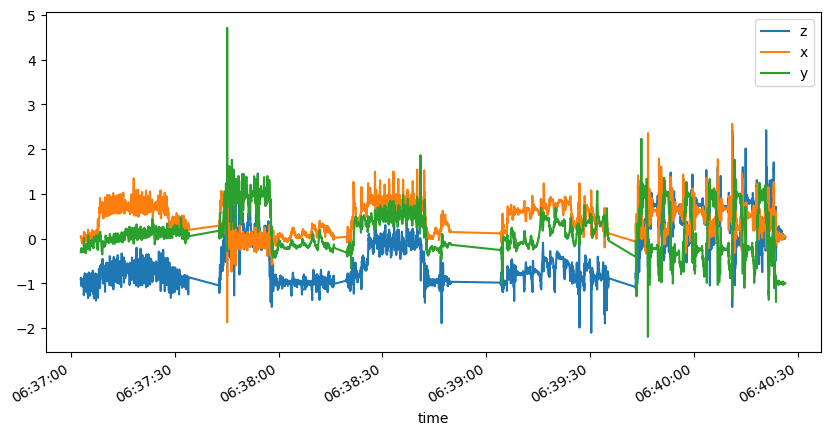

In [49]:
df_walk_acc.plot(figsize=(10,5))

<Axes: xlabel='time'>

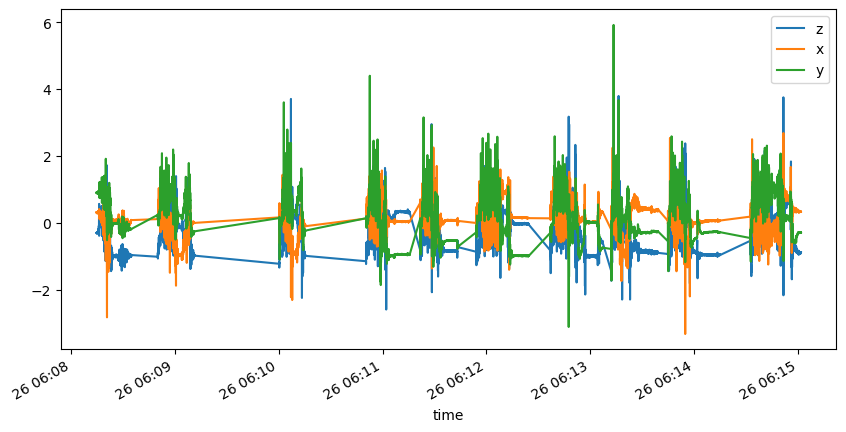

In [50]:
df_fall_acc.plot(figsize=(10,5))

In [51]:
#df_testFall_acc.plot(figsize=(10,5))

<Axes: xlabel='time'>

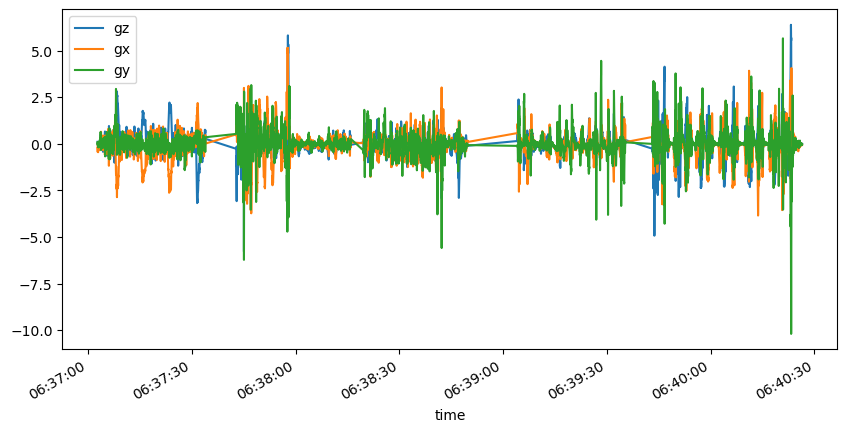

In [52]:
df_walk_gyro.plot(figsize=(10,5))

<Axes: xlabel='time'>

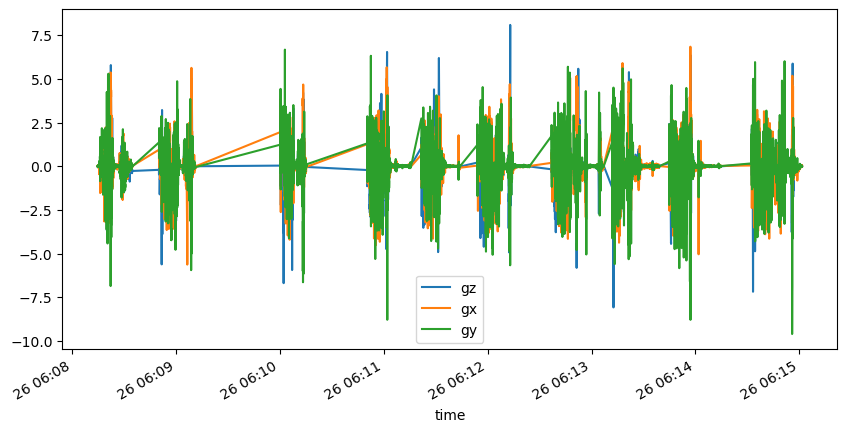

In [53]:
df_fall_gyro.plot(figsize=(10,5))

Vergabe von Labels auf der Basis des Dataframe Ursprungs (Einteilung in Walk und Fall):

-> Verbinden der verschiedenen DataFrames nach Sensoren zu einem kombinierten Dataframe

In [54]:
df_walk_acc['label'] = "walk"
df_fall_acc['label'] = "fall"

df_walk_gyro['label'] = "walk"
df_fall_gyro['label'] = "fall"

df_walk_or['label'] = "walk"
df_fall_or['label'] = "fall"

#df_testFall_acc['label'] = "fall"
#df_testFall_gyro['label'] = "fall"
#df_testFall_or['label'] = "fall"

df_combined_walk = pd.merge(df_walk_acc, df_walk_gyro, on='time')
df_combined_fall = pd.merge(df_fall_acc, df_fall_gyro, on='time')

Check der kombinierten DataFrames:

In [55]:
df_combined_walk.describe()

,z,x,y,gz,gx,gy
count,16804.000000,16804.000000,16804.000000,16804.000000,16804.000000,16804.000000
mean,-0.359589,0.447801,0.152155,0.013911,-0.053715,0.012895
std,0.612164,0.335727,0.476925,0.724195,0.767900,0.701034
min,-2.102219,-1.865341,-2.194763,-5.784245,-3.847979,-10.203156
25%,-0.881378,0.154461,-0.175049,-0.224330,-0.323423,-0.226095
50%,-0.560905,0.485565,0.076530,-0.008847,-0.018447,-0.000353
75%,0.055622,0.701656,0.447498,0.271844,0.236523,0.222029
max,2.423325,2.563126,4.711624,6.394666,5.158084,5.667695


In [56]:
df_combined_fall.head(-5)

,z,x,y,label_x,gz,gx,gy,label_y
time,,,,,,,,
2023-05-26 06:08:14.740640512,-0.301971,0.314224,0.902176,fall,-0.005778,0.034796,0.013658,fall
2023-05-26 06:08:14.750704640,-0.303299,0.309540,0.898483,fall,-0.003921,0.049409,0.011565,fall
2023-05-26 06:08:14.760767488,-0.303635,0.308258,0.899277,fall,0.005598,0.029036,0.002087,fall
2023-05-26 06:08:14.770831616,-0.306824,0.306183,0.893265,fall,0.012638,0.009980,0.004288,fall
2023-05-26 06:08:14.780894464,-0.309921,0.303894,0.887253,fall,0.014550,-0.002406,0.008532,fall
...,...,...,...,...,...,...,...,...
2023-05-26 06:15:01.525281792,-0.902313,0.338669,-0.292252,fall,-0.008214,0.000882,0.005573,fall
2023-05-26 06:15:01.535346944,-0.898300,0.341415,-0.288971,fall,-0.004147,0.023150,-0.012377,fall
2023-05-26 06:15:01.545410816,-0.901611,0.339645,-0.288803,fall,-0.007255,0.036433,-0.020707,fall


Bestimmung der Länge der Datensätze:

In [57]:
df_help = df_combined_walk.reset_index()
print(df_help.iloc[-1,0] - df_help.iloc[0,0])

0 days 00:02:32.560001536


Ausschluss der Spalte "label_x" da redundant: 

In [58]:
df_combined_walk.drop('label_x',axis=1, inplace=True)
df_combined_fall.drop('label_x',axis=1, inplace=True)

Überprüfen der Vollständigkeit des Datensatzes:

In [59]:
laenge = len(df_walk_acc) + len(df_walk_gyro)
print("Doppelte Zeilen in Dataframes, ohne join auf Time:", laenge)
print("Einfache Anzahl an Zeilen, bei richtigem Merge:",len(df_combined_walk))
print("Länge des Merges:", len(df_combined_walk))

Doppelte Zeilen in Dataframes, ohne join auf Time: 33610
Einfache Anzahl an Zeilen, bei richtigem Merge: 16804
Länge des Merges: 16804


Aufteilen der DF's in einzelne Abschnitte mit den Abständen 100 Datenpunkte:
- ToDo: Anpassen der Länge von Sequenzen und deren Auswirkung auf die Modellgüte/ Accuracy

In [60]:
df_combined_walk['id'] = 0
df_combined_fall['id'] = 0

id = 1

var1 = 100
var2 = 100

for i in range(0, len(df_combined_walk)):
    df_combined_walk.iloc[i,7] = id
    

    if i >= var1: 
        var1 = var1 + 100
        id+=1

id +=1

for i in range(0, len(df_combined_fall)):
    
    df_combined_fall.iloc[i,7] = id

    if i >= var2: 
        var2 = var2 + 100
        id+=1  

In [61]:
df_combined_walk

,z,x,y,gz,gx,gy,label_y,id
time,,,,,,,,
2023-05-26 06:37:02.785340672,-0.888412,0.045715,-0.303497,0.112945,-0.211808,0.086207,walk,1
2023-05-26 06:37:02.795404800,-0.881195,0.036469,-0.300583,0.093734,-0.298956,0.018099,walk,1
2023-05-26 06:37:02.805468672,-0.882584,0.027451,-0.292221,0.058636,-0.369759,-0.029381,walk,1
2023-05-26 06:37:02.815532544,-0.897415,0.025818,-0.277084,0.018612,-0.426226,-0.044936,walk,1
2023-05-26 06:37:02.825596672,-0.917740,0.027435,-0.260162,-0.018499,-0.437661,-0.020871,walk,1
...,...,...,...,...,...,...,...,...
2023-05-26 06:39:35.305086208,-0.903915,0.109009,-0.005371,0.039428,0.840119,0.081711,walk,168
2023-05-26 06:39:35.315150080,-0.908691,0.119492,0.008499,0.076716,0.695808,0.097948,walk,168
2023-05-26 06:39:35.325214208,-0.913971,0.131104,-0.000656,0.135836,0.534912,0.125029,walk,169


In [62]:
df_combined_fall

,z,x,y,gz,gx,gy,label_y,id
time,,,,,,,,
2023-05-26 06:08:14.740640512,-0.301971,0.314224,0.902176,-0.005778,0.034796,0.013658,fall,170
2023-05-26 06:08:14.750704640,-0.303299,0.309540,0.898483,-0.003921,0.049409,0.011565,fall,170
2023-05-26 06:08:14.760767488,-0.303635,0.308258,0.899277,0.005598,0.029036,0.002087,fall,170
2023-05-26 06:08:14.770831616,-0.306824,0.306183,0.893265,0.012638,0.009980,0.004288,fall,170
2023-05-26 06:08:14.780894464,-0.309921,0.303894,0.887253,0.014550,-0.002406,0.008532,fall,170
...,...,...,...,...,...,...,...,...
2023-05-26 06:15:01.575603968,-0.895996,0.338715,-0.293152,-0.006286,0.024225,-0.006792,fall,332
2023-05-26 06:15:01.585669120,-0.895630,0.340637,-0.289627,-0.002961,0.014271,0.007406,fall,332
2023-05-26 06:15:01.595732992,-0.891815,0.343185,-0.289780,0.001325,0.012306,0.004526,fall,332


Konkatenieren der verschiedenen Dataframes zu einem gemeinsamen DF:

In [63]:
df_combined = pd.concat([df_combined_walk, df_combined_fall])

In [64]:
df_combined.head(16807)

,z,x,y,gz,gx,gy,label_y,id
time,,,,,,,,
2023-05-26 06:37:02.785340672,-0.888412,0.045715,-0.303497,0.112945,-0.211808,0.086207,walk,1
2023-05-26 06:37:02.795404800,-0.881195,0.036469,-0.300583,0.093734,-0.298956,0.018099,walk,1
2023-05-26 06:37:02.805468672,-0.882584,0.027451,-0.292221,0.058636,-0.369759,-0.029381,walk,1
2023-05-26 06:37:02.815532544,-0.897415,0.025818,-0.277084,0.018612,-0.426226,-0.044936,walk,1
2023-05-26 06:37:02.825596672,-0.917740,0.027435,-0.260162,-0.018499,-0.437661,-0.020871,walk,1
...,...,...,...,...,...,...,...,...
2023-05-26 06:39:35.335278080,-0.908676,0.126099,-0.026703,0.188012,0.335304,0.120423,walk,169
2023-05-26 06:39:35.345342208,-0.883438,0.118698,-0.043762,0.209821,0.095041,0.081147,walk,169
2023-05-26 06:08:14.740640512,-0.301971,0.314224,0.902176,-0.005778,0.034796,0.013658,fall,170


Check auf Nullwerte:

In [65]:
df_combined.isnull().sum()

z          0
x          0
y          0
gz         0
gx         0
gy         0
label_y    0
id         0
dtype: int64

In [66]:
df_combined.reset_index(inplace=True)
df_combined.head()

,time,z,x,y,gz,gx,gy,label_y,id
0,2023-05-26 06:37:02.785340672,-0.888412,0.045715,-0.303497,0.112945,-0.211808,0.086207,walk,1
1,2023-05-26 06:37:02.795404800,-0.881195,0.036469,-0.300583,0.093734,-0.298956,0.018099,walk,1
2,2023-05-26 06:37:02.805468672,-0.882584,0.027451,-0.292221,0.058636,-0.369759,-0.029381,walk,1
3,2023-05-26 06:37:02.815532544,-0.897415,0.025818,-0.277084,0.018612,-0.426226,-0.044936,walk,1
4,2023-05-26 06:37:02.825596672,-0.917740,0.027435,-0.260162,-0.018499,-0.437661,-0.020871,walk,1


In [67]:
df_combined.replace(['walk'],0,inplace=True)
df_combined.replace(['fall'],1,inplace=True)
df_combined.head()

,time,z,x,y,gz,gx,gy,label_y,id
0,2023-05-26 06:37:02.785340672,-0.888412,0.045715,-0.303497,0.112945,-0.211808,0.086207,0,1
1,2023-05-26 06:37:02.795404800,-0.881195,0.036469,-0.300583,0.093734,-0.298956,0.018099,0,1
2,2023-05-26 06:37:02.805468672,-0.882584,0.027451,-0.292221,0.058636,-0.369759,-0.029381,0,1
3,2023-05-26 06:37:02.815532544,-0.897415,0.025818,-0.277084,0.018612,-0.426226,-0.044936,0,1
4,2023-05-26 06:37:02.825596672,-0.917740,0.027435,-0.260162,-0.018499,-0.437661,-0.020871,0,1


Berechnen der extracted_features mit tsfresh: 

from tsfresh import extract_features
extracted_features = extract_features(df_combined, column_id="id",column_sort='time')

Ausgeben der errechneten Features mittels TsFresh:

In [68]:
#extracted_features

In [69]:
labels= df_combined[['id','label_y']]
labels= labels.drop_duplicates()
labels= labels.set_index('id')
y= labels.iloc[:,0]
y.duplicated().sum()

#print(y)


330

ACHTUNG: select_features vs. extract_relevant_features Unterschied ermitteln, Recherche

Features_filtered wird nicht weiter benutzt

from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
#test
impute(extracted_features)
features_filtered = select_features(extracted_features,y)

In [70]:
from tsfresh import extract_relevant_features

features_filtered_direct = extract_relevant_features(df_combined, y,
                                                     column_id='id', column_sort='time')

Feature Extraction:   0%|          | 0/25 [00:02<?, ?it/s]


TypeError: acf() got an unexpected keyword argument 'unbiased'

features_filtered.columns

In [ ]:
features_filtered_direct.columns

Index(['label_y__count_below__t_0',
       'label_y__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)',
       'label_y__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)',
       ...
       'label_y__range_count__max_1__min_-1', 'label_y__value_count__value_0',
       'z__permutation_entropy__dimension_7__tau_1',
       'gz__ratio_beyond_r_sigma__r_3',
       'z__permutation_entropy__dimension_6__tau_1',
       'z__permutation_entropy__dimension_5__tau_1',
       'z__permuta

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_filtered_direct, y, test_size=0.30, random_state=101)

In [ ]:
y_test

id
86     1
26     0
103    1
33     0
109    1
17     0
2      0
51     0
48     0
49     0
32     0
56     0
14     0
99     1
62     0
85     1
46     0
22     0
72     0
7      0
91     1
68     0
95     1
15     0
55     0
83     1
90     1
54     0
4      0
59     0
47     0
44     0
58     0
Name: label_y, dtype: int64

In [ ]:
#KNN
knn = KNeighborsClassifier(n_neighbors=3,weights='distance')
knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)

In [ ]:
#Test via Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[24  0]
 [ 0  9]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#randomforest
rf= RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

#Test via Konfusionsmatrix
dm = confusion_matrix(y_test, y_pred)
print(dm)

[[24  0]
 [ 0  9]]
